In [4]:
import pandas as pd
# Load the datasets
housing_data = pd.read_csv("Ames_HousePrice.csv")
real_estate_data = pd.read_csv("Ames Real Estate Data.csv")
merged_data= pd.read_csv("Cleaned_Ames_Housing_Data.csv")

C:\Users\Chloe DeRouen\AppData\Local\Temp\ipykernel_22044\120841399.py:4: DtypeWarning: Columns (36,40,81,87) have mixed types. Specify dtype option on import or set low_memory=False.
  real_estate_data = pd.read_csv("Ames Real Estate Data.csv")


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Select features and target variable
features = [
    'GrLivArea', 'OverallQual', 'TotalBsmtSF', 'GarageCars', 'AgeOfHouse',
    'TimeSinceLastRemodel', 'LotFrontageToLotAreaRatio', 'TotalOutdoorSpace',
    'LivingSpaceEfficiency'
]

# Ensure selected features exist
for feature in features:
    if feature not in merged_data.columns:
        print(f"Feature '{feature}' is missing in merged_data.")

X = merged_data[features]
y = merged_data['SalePrice']

# Handle missing values (if any)
X = X.fillna(X.median())
y = y.fillna(y.median())  # Optional; typically, missing target rows are removed.

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features (optional for linear regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [7]:
import xgboost as xgb
from xgboost import XGBRegressor

# Assuming `X` and `y` are already defined
# Split the dataset into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Initialize and train the baseline XGBoost model
xgb_baseline = XGBRegressor(random_state=42, eval_metric='rmse')
xgb_baseline.fit(X_train, y_train)

# Make predictions and evaluate performance
y_pred_baseline = xgb_baseline.predict(X_test)

# Evaluate baseline performance
from sklearn.metrics import mean_squared_error, r2_score

mse_baseline = mean_squared_error(y_test, y_pred_baseline)
r2_baseline = r2_score(y_test, y_pred_baseline)
print("Baseline XGBoost MSE:", mse_baseline)
print("Baseline XGBoost R^2 Score:", r2_baseline)

Baseline XGBoost MSE: 648072148.4609271
Baseline XGBoost R^2 Score: 0.8999513801007283


In [12]:
#cross validation*
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Define the scoring metric (negative mean squared error)
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Perform cross-validation
cv_scores = cross_val_score(
    XGBRegressor(random_state=42, eval_metric='rmse'), 
    X_train, 
    y_train, 
    cv=5,  # 5-fold cross-validation
    scoring=scorer
)

# Convert negative MSE to positive values
cv_mse_scores = -cv_scores
print("Cross-Validation MSE Scores:", cv_mse_scores)
print("Mean CV MSE:", cv_mse_scores.mean())
print("Standard Deviation of CV MSE:", cv_mse_scores.std())


Cross-Validation MSE Scores: [1.45540939e+09 7.82332770e+08 8.60463131e+08 7.05914735e+08
 6.90704595e+08]
Mean CV MSE: 898964924.6270307
Standard Deviation of CV MSE: 284730270.112415


In [20]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 2, 5]
}

# Initialize the XGBoost model
xgb_model = XGBRegressor(random_state=42, eval_metric='rmse')

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and model
print("Best Parameters:", grid_search.best_params_)
best_xgb_model = grid_search.best_estimator_

Best Parameters: {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'reg_alpha': 1, 'reg_lambda': 5, 'subsample': 0.8}


In [22]:
best_params = grid_search.best_params_

Tuned XGBoost MSE: 473910124.5806999
Tuned XGBoost R^2 Score: 0.9268383095413186


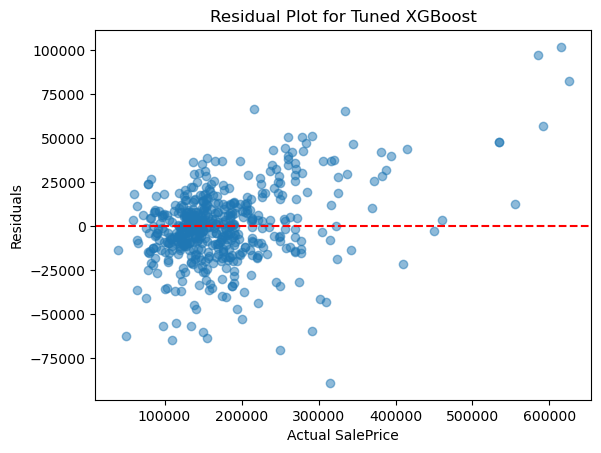

In [24]:
# Predict on the test set using the best model
y_pred_tuned = best_xgb_model.predict(X_test)

# Evaluate performance
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)
print("Tuned XGBoost MSE:", mse_tuned)
print("Tuned XGBoost R^2 Score:", r2_tuned)

# Residual plot
import matplotlib.pyplot as plt

residuals = y_test - y_pred_tuned
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Actual SalePrice")
plt.ylabel("Residuals")
plt.title("Residual Plot for Tuned XGBoost")
plt.show()


In [26]:
from xgboost import XGBRegressor

best_model = XGBRegressor(random_state=42)
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Feature Importance:
                      Feature  Importance
1                OverallQual    0.358238
3                 GarageCars    0.309812
0                  GrLivArea    0.106369
2                TotalBsmtSF    0.084456
4                 AgeOfHouse    0.056124
5       TimeSinceLastRemodel    0.038947
7          TotalOutdoorSpace    0.021092
6  LotFrontageToLotAreaRatio    0.016115
8      LivingSpaceEfficiency    0.008846


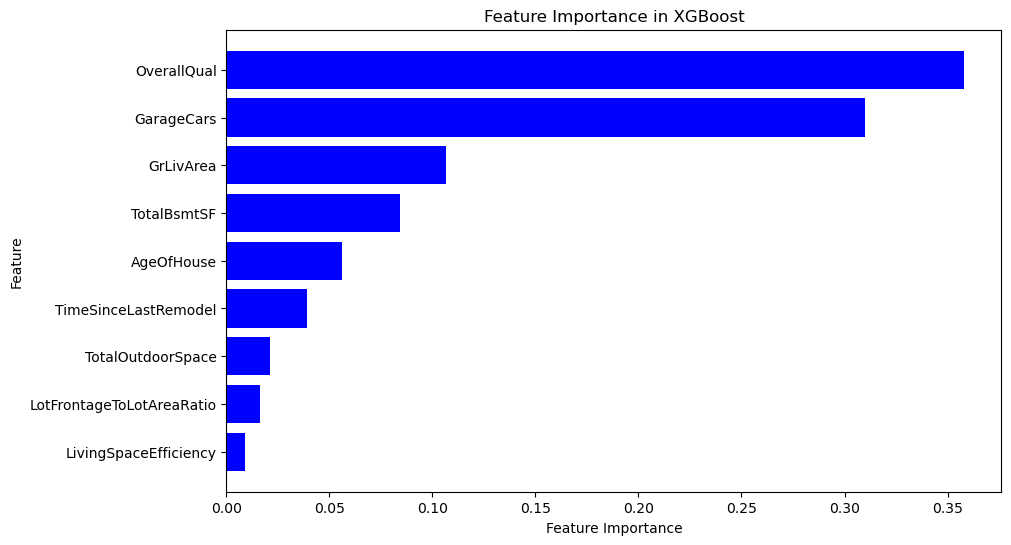

<Figure size 640x480 with 0 Axes>

In [28]:
import pandas as pd

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importance:\n", feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='blue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in XGBoost")
plt.gca().invert_yaxis()
plt.show()

# Save the plot as a PNG
plt.savefig("xgboost_feature_importance.png", dpi=300)
plt.show()

In [40]:
from sklearn.model_selection import cross_val_score
import xgboost as xgb

# Initialize model with best parameters
xgb_model = xgb.XGBRegressor(random_state=42, **best_params)

# Perform cross-validation for MSE
mse_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Perform cross-validation for R^2
r2_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='r2')

# Print MSE results
print(f"Cross-Validation MSE Scores: {-mse_scores}")  # Convert negative MSE to positive
print(f"Mean CV MSE: {-mse_scores.mean()}")
print(f"Standard Deviation of CV MSE: {mse_scores.std()}")

# Print R^2 results
print(f"Cross-Validation R^2 Scores: {r2_scores}")
print(f"Mean CV R^2: {r2_scores.mean()}")
print(f"Standard Deviation of CV R^2: {r2_scores.std()}")



Cross-Validation MSE Scores: [9.44804620e+08 7.05039950e+08 6.01171300e+08 5.24994967e+08
 5.67138198e+08]
Mean CV MSE: 668629806.8580025
Standard Deviation of CV MSE: 150386428.93282387
Cross-Validation R^2 Scores: [0.83892551 0.88328022 0.88517326 0.90228504 0.88839551]
Mean CV R^2: 0.8796119080046643
Standard Deviation of CV R^2: 0.021405561686682086


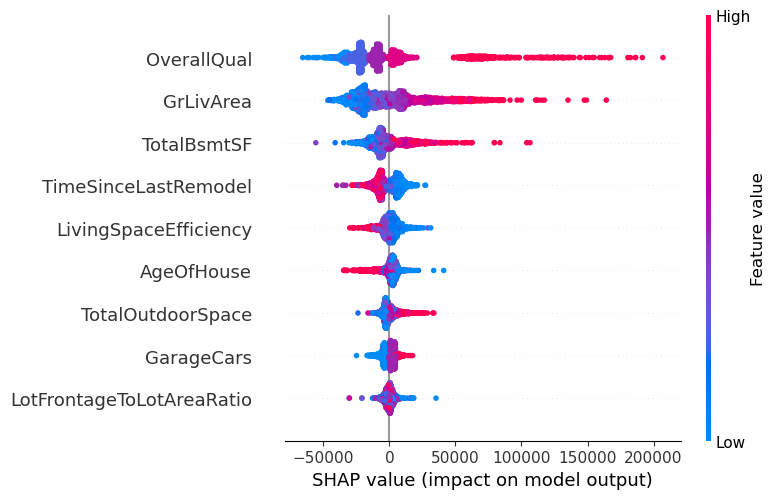

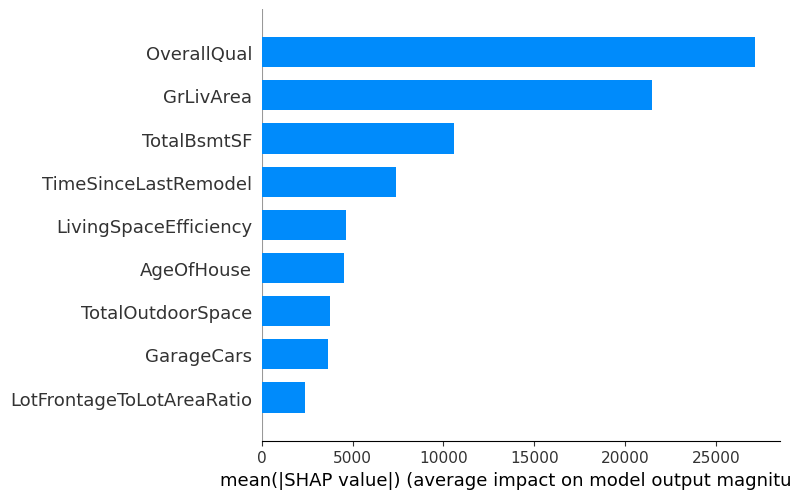

In [32]:
import shap

# Create SHAP explainer
explainer = shap.Explainer(best_model)

# Get SHAP values
shap_values = explainer.shap_values(X_train)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train)

# SHAP feature importance plot
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [36]:
import shap
import matplotlib.pyplot as plt

# Create SHAP explainer
explainer = shap.Explainer(best_model)

# Get SHAP values
shap_values = explainer.shap_values(X_train)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train, show=False)
plt.title("SHAP Summary Plot")
plt.tight_layout()
plt.savefig("shap_summary_plot.png", dpi=300)
plt.close()  # Close the figure to avoid overlap

# SHAP feature importance bar plot
shap.summary_plot(shap_values, X_train, plot_type="bar", show=False)
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.savefig("shap_feature_importance_bar_plot.png", dpi=300)
plt.close()


In [ ]:
#possibly find more shap models to use for visuals 
#natively handle missing values

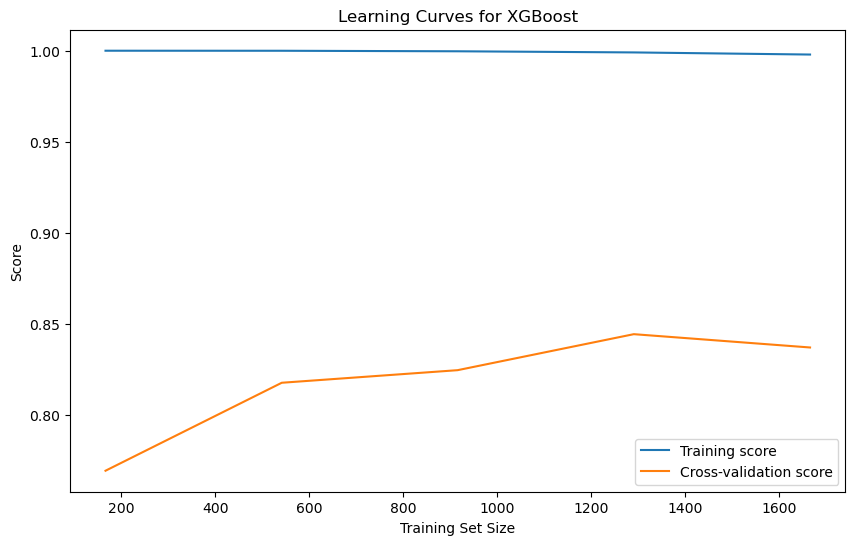

In [32]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Cross-validation score')
plt.title('Learning Curves for XGBoost')
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.legend()
plt.show()

#test score vs cross validation**** training r^2 vs test r^2
#cross validation (keep seperate from train/test)
#don't attempt until you know how the two behave
#cross_val_score in cross validation *possibly mean of cv*
#don't change size of the training set
#have purpose in project
#naming conventions
#cross validation in isolation (plot cross validation possibly)

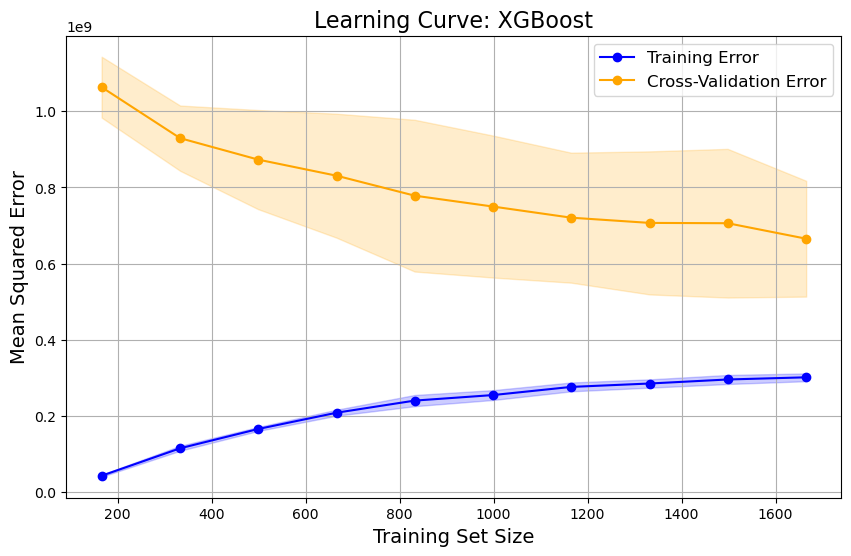

In [44]:
from sklearn.model_selection import learning_curve
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np

# Initialize the XGBoost model
xgb_model = XGBRegressor(random_state=42, **best_params)

# Compute learning curve
train_sizes, train_scores, test_scores = learning_curve(
    xgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

# Convert negative MSE scores to positive
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Error', color='blue', marker='o')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes, test_scores_mean, label='Cross-Validation Error', color='orange', marker='o')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color='orange')

# Add labels, title, and legend
plt.title('Learning Curve: XGBoost', fontsize=16)
plt.xlabel('Training Set Size', fontsize=14)
plt.ylabel('Mean Squared Error', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(True)
plt.show()
